### Import libraries

In [4]:
import os
import pickle
import requests
import bs4 as bs
import numpy as np
import pandas as pd
import datetime as dt
import warnings as wn
from statistics import mean
from matplotlib import style
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_datareader.data as web
from mpl_finance import candlestick_ohlc
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

style.use('ggplot')
wn.filterwarnings('ignore')

### Set start/end dates for stock information

In [5]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.now()

### Tesla adjusted close graph with 100 day moving average (100ma):

- $100ma =  mid-term trend-following indicator. It uses last 100 days or 20 weeks show price movement. When the price of a security is above its 100-day moving average it is considered bullish and when the price is below, it is considered bearish.

- $\text{100ma = }\frac{\text{ sum of prices of the last 100 days}}{\text{100}}$

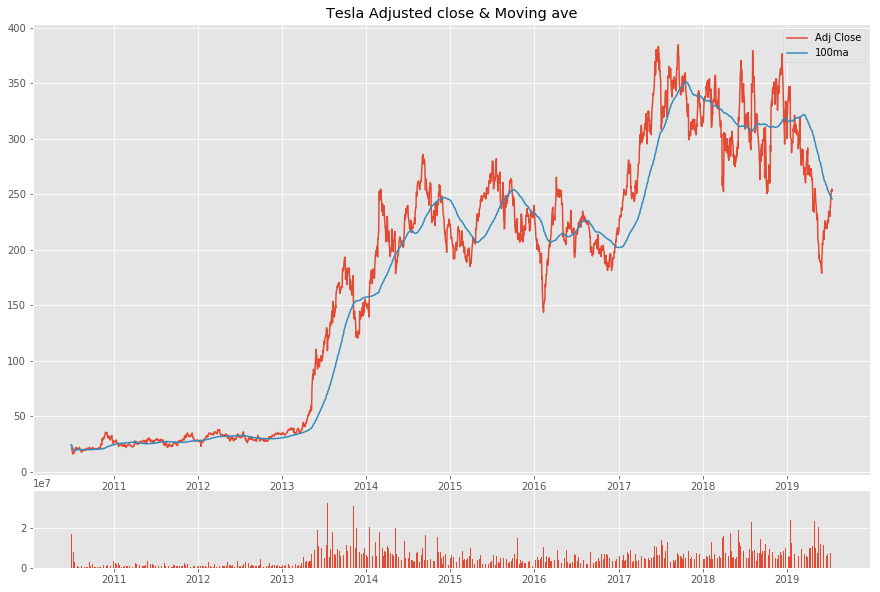

In [8]:
# parse_dates=True; allows pandas to automatically recognize dates in dataframe
df = pd.read_csv('TSLA.csv', parse_dates=True, index_col=0)

# Reset index to date
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

# Adjusted close = closing price after adjustments for all applicable splits and dividend distributions

df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1, title='Tesla Adjusted close & Moving ave')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])
ax1.legend()
plt.show()


### Tesla ohlc(open high low close)/volume graph
- Volume: number of shares
- ohlc: Each thin vertical line shows the overall days time price range (high and low)
    - Each thick vertical line shows the days open and close price. 
    - Close above open = red; Close below open = red.


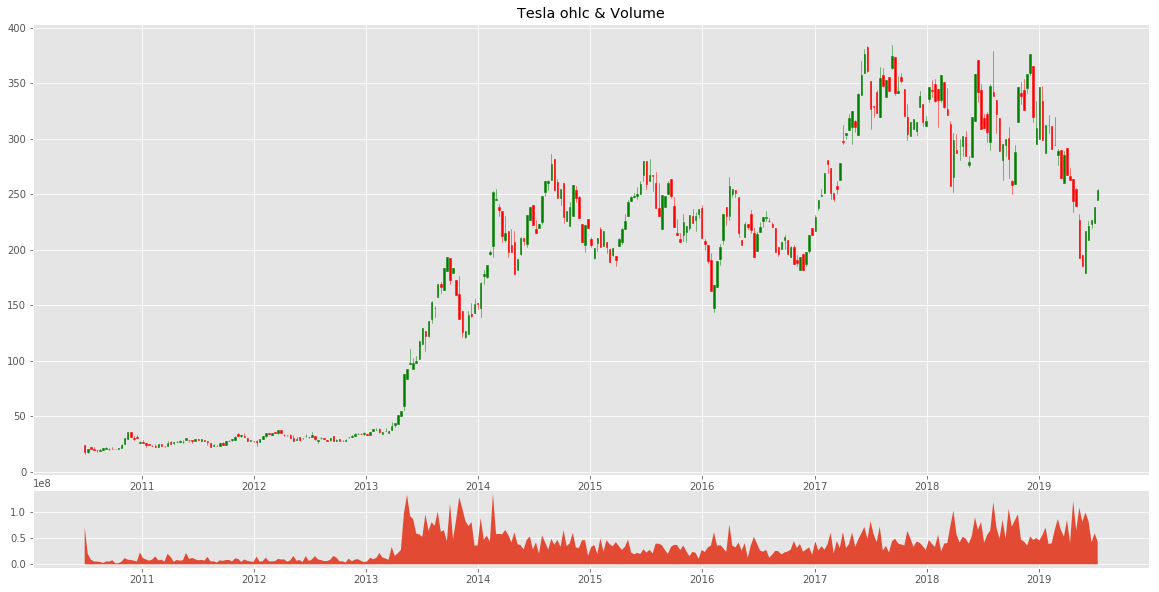

In [9]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1, title='Tesla ohlc & Volume')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()
candlestick_ohlc(ax1, df_ohlc.values, width=5, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()

In [10]:
def save_sp500_tickers():
    '''
    Save s&p500 tickers to pickle file
    '''
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]
        tickers.append(ticker)
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
    return tickers
# save_sp500_tickers()

def get_data_from_yahoo(reload_sp500=False):
    '''
    Grabs saved tickers from sp500tickers.pickle and uses pandas datareader api to pull data from each stock.
    Saves the stock info into a folder in .csv format. 
    Each file contains stock data for: ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    '''
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
#     if not os.path.exists('stock_dfs'):
#         os.makedirs('stock_dfs')
    for ticker in tickers:
        # In case connection breaks, save progress.
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.get_data_yahoo(ticker.replace('.','-'), start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
# get_data_from_yahoo()

In [11]:
# a = pd.read_pickle('./sp500tickers.pickle', compression='infer')
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
compile_data()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                  MMM        ABT  ABBV  ABMD        ACN       ATVI       ADBE  \
Date                                                                            
2010-01-04  65.240753  20.555250   NaN  8.74  34.148254  10.193225  37.090000   
2010-01-05  64.832115  20.389175   NaN  8.53  34.359306  10.211267  37.700001   
2010-01-06  65.751556  20.502405   NaN  8.40  34.724575  10.157144  37.619999   
2010-01-07  65.798698  20.672255   NaN  8.40  34.692101   9.913588  36.889999   
2010-01-08  66.262344  20.777939   NaN  8.23  34.554115   9.832404  36.689999   

             AMD        AAP        AES  ...       WLTW       WYNN        XEL  \
Date                                    ...                                    
2010-01-04  9.70  39.434929  11.029709  ...  62.950756  46.207447  14.690097   

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.877301  0.926302  0.821199  0.938578  0.931338  0.867424   
ABT   0.877301  1.000000  0.835418  0.892283  0.957248  0.820855  0.958582   
ABBV  0.926302  0.835418  1.000000  0.891059  0.901428  0.905114  0.885715   
ABMD  0.821199  0.892283  0.891059  1.000000  0.913121  0.895219  0.963133   
ACN   0.938578  0.957248  0.901428  0.913121  1.000000  0.918149  0.961757   

           AMD       AAP       AES  ...      WLTW      WYNN       XEL  \
MMM   0.538597  0.727829  0.516895  ...  0.911939  0.433810  0.931836   
ABT   0.717764  0.709935  0.771917  ...  0.947513  0.406838  0.939569   
ABBV  0.710678  0.250083  0.409239  ...  0.856798  0.209532  0.821852   
ABMD  0.781863  0.548963  0.641591  ...  0.856359  0.304048  0.859863   
ACN   0.700337  0.714579  0.648064  ...  0.962326  0.369816  0.976398   

           XRX      XLNX       XYL       YUM       ZBH      ZION       ZTS  
MMM   0.732519 

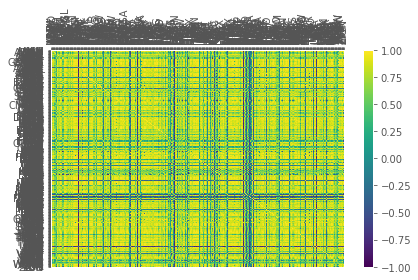

In [12]:
def visualize_data():
    '''
    Visualize data for s&p500 correlation plot: adjusted close pricing.
    Views heatmap and numbers-plot.
    Computes pairwise *correlation of columns, excluding NA/null values -- Exports to csv. 
      * pearson : standard correlation coefficient
    
    '''
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    print(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values # Grab values from correlation plot
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.show()
visualize_data()

### All machine learning takes "featuresets" and attempts to map them to "labels."
Features can be lot's of things such as other companies prices, moving averages, and lot's of other things. <br>
Feature = pricing changes for that day for all companies. <br>
Label = whether to buy a specific company stock or not. 



What we're looking for: 
- in the next 7 days:
    - buy = price increase > 2%
    - sell = price decrease > 2%
    - hold = (decrease < 2%) or (increase < 2%) 
    
Note: Due to the market tending towards providing a greater and greater return over time we may need to increase the +2% to make up for that. 

In [13]:
def process_data_for_labels(ticker):
    '''
    Creates column '{ticker}_{day#}d'
    Close price ith days in the future up to 7 days - Todays Close price / Todays Close price
    new - old / old
    Represented as a %
    7 day % price changes for the future
    '''
    hm_days = 7 # how many days
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df

In [14]:
def buy_sell_hold(*args):
    '''
    Create labels and maps function to dataframe.
    Pass future price change columns in as args; which iterates automagically through rows. 
    Buy=1, Sell=-1, Hold=0
    '''
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0


In [15]:
def extract_featuresets(ticker):
    '''
    Takes any ticker, creates needed dataset, and creates our target(label) column. 
    Target column has -1, 0, or 1 for each row, based on our function and the columns we feed through. 
    Turns dataframe values into % change.
    Returns X(Labels), y(Features), and dataframe as % change.
    '''
    tickers, df = process_data_for_labels(ticker)
    # Create list that maps(iterator that computes) buy_sell_hold function to create df columns
    # Creates column for each company, stating whether to buy/hold/sell with a 1/0/-1 respectively. 
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold, df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)], df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)], df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)], df['{}_7d'.format(ticker)] ))
    vals = df['{}_target'.format(ticker)].values.tolist() # place 1/0/-1 values into list 
    str_vals = [str(i) for i in vals] # convert values to strings so that 
    print('Data spread:',Counter(str_vals)) # prints distribution of 1/0/-1 values
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    # set x values to prices only, if we include other columns it will lead to overfitting.
    df_vals = df[[ticker for ticker in tickers]].pct_change() # Print % change for all values, this normalizes our data
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    # Set our Features and labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values

    return X,y,df

In [16]:
def do_ml(ticker):
    '''
    Pulls data from extract_featuresets().
    Splits into train/test.
    Runs SVM, K-nearest neighbors, and Random forest classifier -- compares using voting function.
    Checks for accuracy scores.
    Runs prediction, and returns predictions represented as spread counts ie (1=300,0=200,-1=400)
    '''
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)

    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])

    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('accuracy:', confidence)
    predictions = clf.predict(X_test)
    print('predicted class counts:', Counter(predictions))
    print()
    print()
    return confidence

# examples of running:
do_ml('XOM')
do_ml('AAPL')
do_ml('ABT')

Data spread: Counter({'0': 925, '1': 790, '-1': 686})
accuracy: 0.37104825291181365
predicted class counts: Counter({0: 281, -1: 252, 1: 68})


Data spread: Counter({'1': 1095, '-1': 892, '0': 414})
accuracy: 0.4209650582362729
predicted class counts: Counter({1: 328, -1: 269, 0: 4})


Data spread: Counter({'1': 939, '0': 794, '-1': 668})
accuracy: 0.3610648918469218
predicted class counts: Counter({1: 296, -1: 186, 0: 119})




0.3610648918469218

Because we have 3 options, ie buy/sell/hold, the average would be 33%.<br>
For the 3 example companies, we can see that our result were all above average accuracy; ~37%, ~42%, ~36%.

What I expected to see was for the buy and hold to be the dominate execution. Seeing how the market tends to go up.

#### Let's review the data:
- <pre>actual: {'0': 925, '1': 790, '-1': 686}      0:1, 1:2, -1:3</pre>
- <pre>predicted: {0: 281, -1: 252, 1: 68}          0:1, 1:3, -1:2</pre>
<br>
- <pre>actual: {'1': 1095, '-1': 892, '0': 414}     0:3, 1:1, -1:2</pre>
- <pre>predicted: {1: 328, -1: 269, 0: 4}           0:3, 1:1, -1:2</pre>
<br>
- <pre>actual: {'1': 939, '0': 794, '-1': 668}      0:2, 1:1, -1:3</pre>
- <pre>predicted: {1: 296, -1: 186, 0: 119}         0:3, 1:1, -1:2</pre>

#### Results:
<pre>
 0(1):2    0(2):1    0(3):3
 1(1):4    1(2):1    1(3):1
-1(1):0   -1(2):4   -1(3):2
</pre>
With a random selection of companies, we can see that the buy and hold did indeed have the slight advantage. <br>
However, the predicted spreads were not the same as the actual spread. This, to me, is a problem.


In [103]:
# Runs machine learning models on all companies in the s&p500
with open("sp500tickers.pickle","rb") as f:
    tickers = pickle.load(f)

accuracies = []
for count,ticker in enumerate(tickers):
    if count%10==0:
        print(count)
    accuracy = do_ml(ticker)
    accuracies.append(accuracy)
    print("{} accuracy: {}. Average accuracy:{}".format(ticker,accuracy,mean(accuracies)))

0
Data spread: Counter({'0': 890, '1': 878, '-1': 633})
accuracy: 0.34608985024958405
predicted class counts: Counter({0: 305, -1: 175, 1: 121})


MMM accuracy: 0.34608985024958405. Average accuracy:0.34608985024958405
Data spread: Counter({'1': 939, '0': 794, '-1': 668})
accuracy: 0.3643926788685524
predicted class counts: Counter({1: 327, -1: 152, 0: 122})


ABT accuracy: 0.3643926788685524. Average accuracy:0.35524126455906824
Data spread: Counter({'0': 1047, '1': 779, '-1': 575})
accuracy: 0.48914858096828046
predicted class counts: Counter({0: 263, -1: 201, 1: 135})


ABBV accuracy: 0.48914858096828046. Average accuracy:0.3998770366954723
Data spread: Counter({'1': 1297, '-1': 957, '0': 147})
accuracy: 0.4875207986688852
predicted class counts: Counter({1: 377, -1: 224})


ABMD accuracy: 0.4875207986688852. Average accuracy:0.42178797718882555
Data spread: Counter({'1': 1006, '0': 728, '-1': 667})
accuracy: 0.39434276206322794
predicted class counts: Counter({1: 293, 0: 181, -1: 1